In [51]:
import os

import numpy as np
import pandas as pd

from lmfit import minimize, Parameters

from matplotlib import pyplot as plt, rc, rcParams#, ticker

In [37]:
# inline interactive plotting
%matplotlib notebook
rcParams['figure.figsize'] = [10,7.5]
rcParams['figure.dpi'] = 100

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
text = {'usetex': True}
rc('font', **font)
# rc('text', **text)

In [9]:
# Define sample parameters 
# He3 sample is TmVO4-LS5200-needles, DR sample is TmVO4-LS5228-DR-HC1807
samples = {0:'TmVO4-LS5200',
           1:'TmVO4-LS5228-DR-HC1807'}

Hc_data_dir = {samples[0]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields', 
               samples[1]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields'}

Hc_data_file = {samples[0]:'2021-05-26_TmVO4-LS5200_Hc_all_runs.csv',
                samples[1]:'2021-05-27_TmVO4-LS5228-DR-HC1807_Hc_all_runs.csv'}

# Choose which sample to work with
sample = samples[0]

In [8]:
os.chdir(Hc_data_dir[sample])
print(os.getcwd())

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields


In [18]:
Hc_df = pd.read_csv(Hc_data_file[sample], comment='#')
Hc_df

,Date,Run number,Sweeprate,Tbath,Hc_measured,Tc,dHc,deltaHc,deltaHcErr,rhc,Hc_inferred
0,7/29/2017,2,4.0,0.7,4986.2800,0.773508,20.007623,0.001749,0.004013,0.997,4971.321160
1,7/29/2017,2,4.0,0.8,4952.6110,0.872783,20.007623,0.006540,0.004040,0.997,4937.753167
2,7/29/2017,2,4.0,0.9,4919.5615,0.974800,20.007623,0.004155,0.004067,0.997,4904.802816
3,7/29/2017,2,4.0,1.0,4858.6150,1.074363,20.007623,0.001314,0.004118,0.997,4844.039155
4,7/29/2017,2,4.0,1.1,4761.6620,1.174873,20.007623,0.002801,0.004202,0.997,4747.377014
5,7/29/2017,2,4.0,1.2,4671.3710,1.275230,20.007623,-0.002434,0.004283,0.997,4657.356887
6,7/29/2017,2,4.0,1.3,4532.3525,1.375687,20.007623,-0.006035,0.004414,0.997,4518.755442
7,7/29/2017,2,4.0,1.4,4363.9425,1.474509,20.007623,-0.006632,0.004585,0.997,4350.850672
8,7/29/2017,2,10.0,1.0,4857.1845,1.073877,29.901441,0.001609,0.006156,0.997,4842.612946
9,7/29/2017,2,10.0,1.1,4804.3685,1.176073,29.901441,-0.006113,0.006224,0.997,4789.955395


<IPython.core.display.Javascript object>


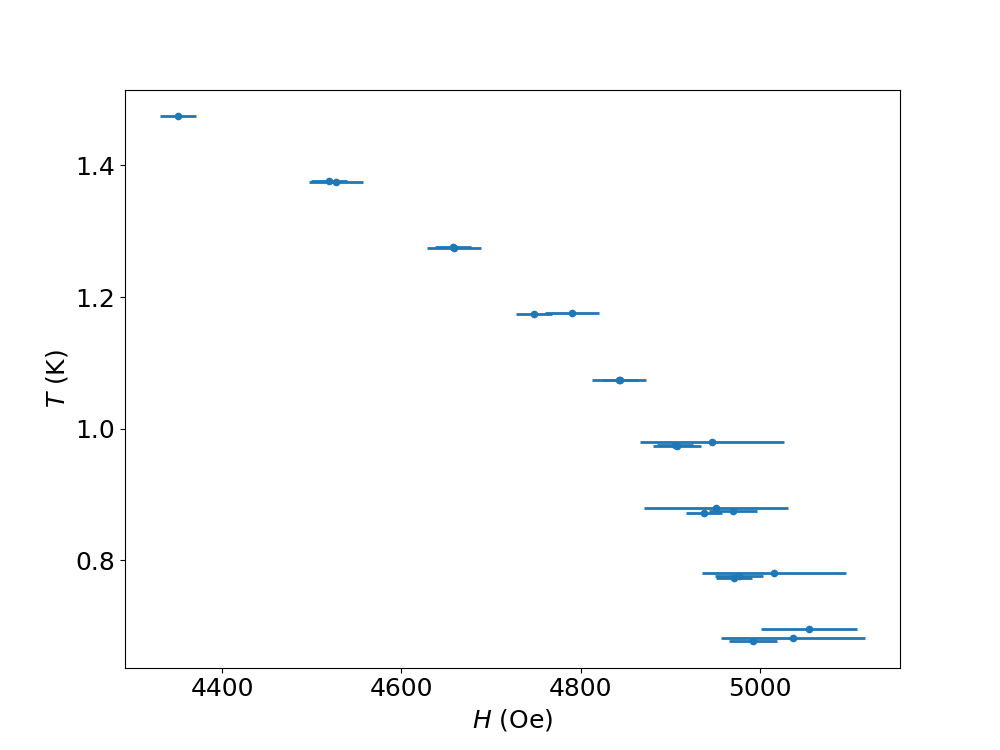

In [50]:
fig, ax = plt.subplots()
plt.errorbar(Hc_df['Hc_inferred'], Hc_df['Tc'], xerr=Hc_df['dHc'], marker='.', ms=9, lw=0, elinewidth=2)
ax.set_xlabel(r'$H$ (Oe)')
ax.set_ylabel(r'$T$ (K)')
plt.locator_params(nbins=6)

In [92]:
def sc_tfim(x):
    return x/np.arctanh(x)

def sc_tfim_residual(params, x, data, eps_data=None):
    Tc = params['Tc']
    Hc = params['Hc']
    
    model = Tc*sc_tfim(x/Hc)

    if eps_data==None:
        yres = (data-model)
        return yres[~np.isnan(yres)]
    else:
        return (data-model)/eps_data

In [96]:
params = Parameters()
params.add('Tc', value=2.2)
params.add('Hc', value=5.1e3)

x = Hc_df['Hc_inferred']
y = Hc_df['Tc']
ysel = y>.8
out = minimize(sc_tfim_residual, params, args=(x[ysel], y[ysel]))
# Hc_df['Hc_inferred']
# Hc_df['Hc_inferred'][~np.isnan(1/np.arctanh(Hc_df['Hc_inferred']/5.05e3))]
# # sc_tfim_residual(params, Hc_df['Hc_inferred'], Hc_df['Tc'])
out